In [2]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt

ox.config(log_console=True, use_cache=True)
ox.__version__

In [35]:
cities = pd.read_html("https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population")
cities = cities[4]

cities = pd.DataFrame({'city': cities['City'].str.replace('\[.*\]', ''),
                       'state': cities['State[c]']})

In [36]:
cities.head()

,city,state
0,New York City,New York
1,Los Angeles,California
2,Chicago,Illinois
3,Houston,Texas
4,Phoenix,Arizona


In [7]:
import json
import googlemaps

with open("google.json", "r") as token:
    GOOGLE_KEY = json.load(token)["key"]
    
gmaps = googlemaps.Client(key=GOOGLE_KEY)

In [21]:
street_widths = {'footway' : 0.5,
                 'steps' : 0.5,
                 'pedestrian' : 0.5,
                 'path' : 0.5,
                 'track' : 0.5,
                 'service' : 2,
                 'residential' : 3,
                 'primary' : 5,
                 'motorway' : 6}

In [34]:
lats = list()
lons = list()

for i in np.arange(0, len(cities.city)):
    metro = cities['city'][i]
    state = cities['state'][i]
    
    location = f"City Hall, {metro}, {state}, USA"
    
    result = gmaps.geocode(location)

    lats.append(result[0]['geometry']['location']['lat'])
    lons.append(result[0]['geometry']['location']['lng'])

In [37]:
cities['lat'] = lats
cities['lon'] = lons

<AxesSubplot:>

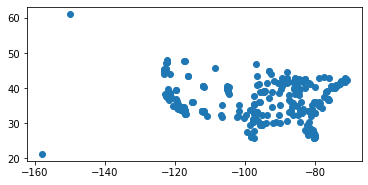

In [40]:
gpd.GeoDataFrame(cities, geometry=gpd.points_from_xy(cities.lon, cities.lat))

In [54]:
G = ox.graph_from_point((cities['lat'][0], cities['lon'][0]), 
                        dist=1000, 
                        network_type='all')

In [62]:
gdfs = ox.graph_to_gdfs(G)
node = gdfs[0]
edge = gdfs[1]

In [75]:
bbox = ox.utils_geo.bbox_from_point((cities['lat'][0], cities['lon'][0]), 800, project_utm=False)

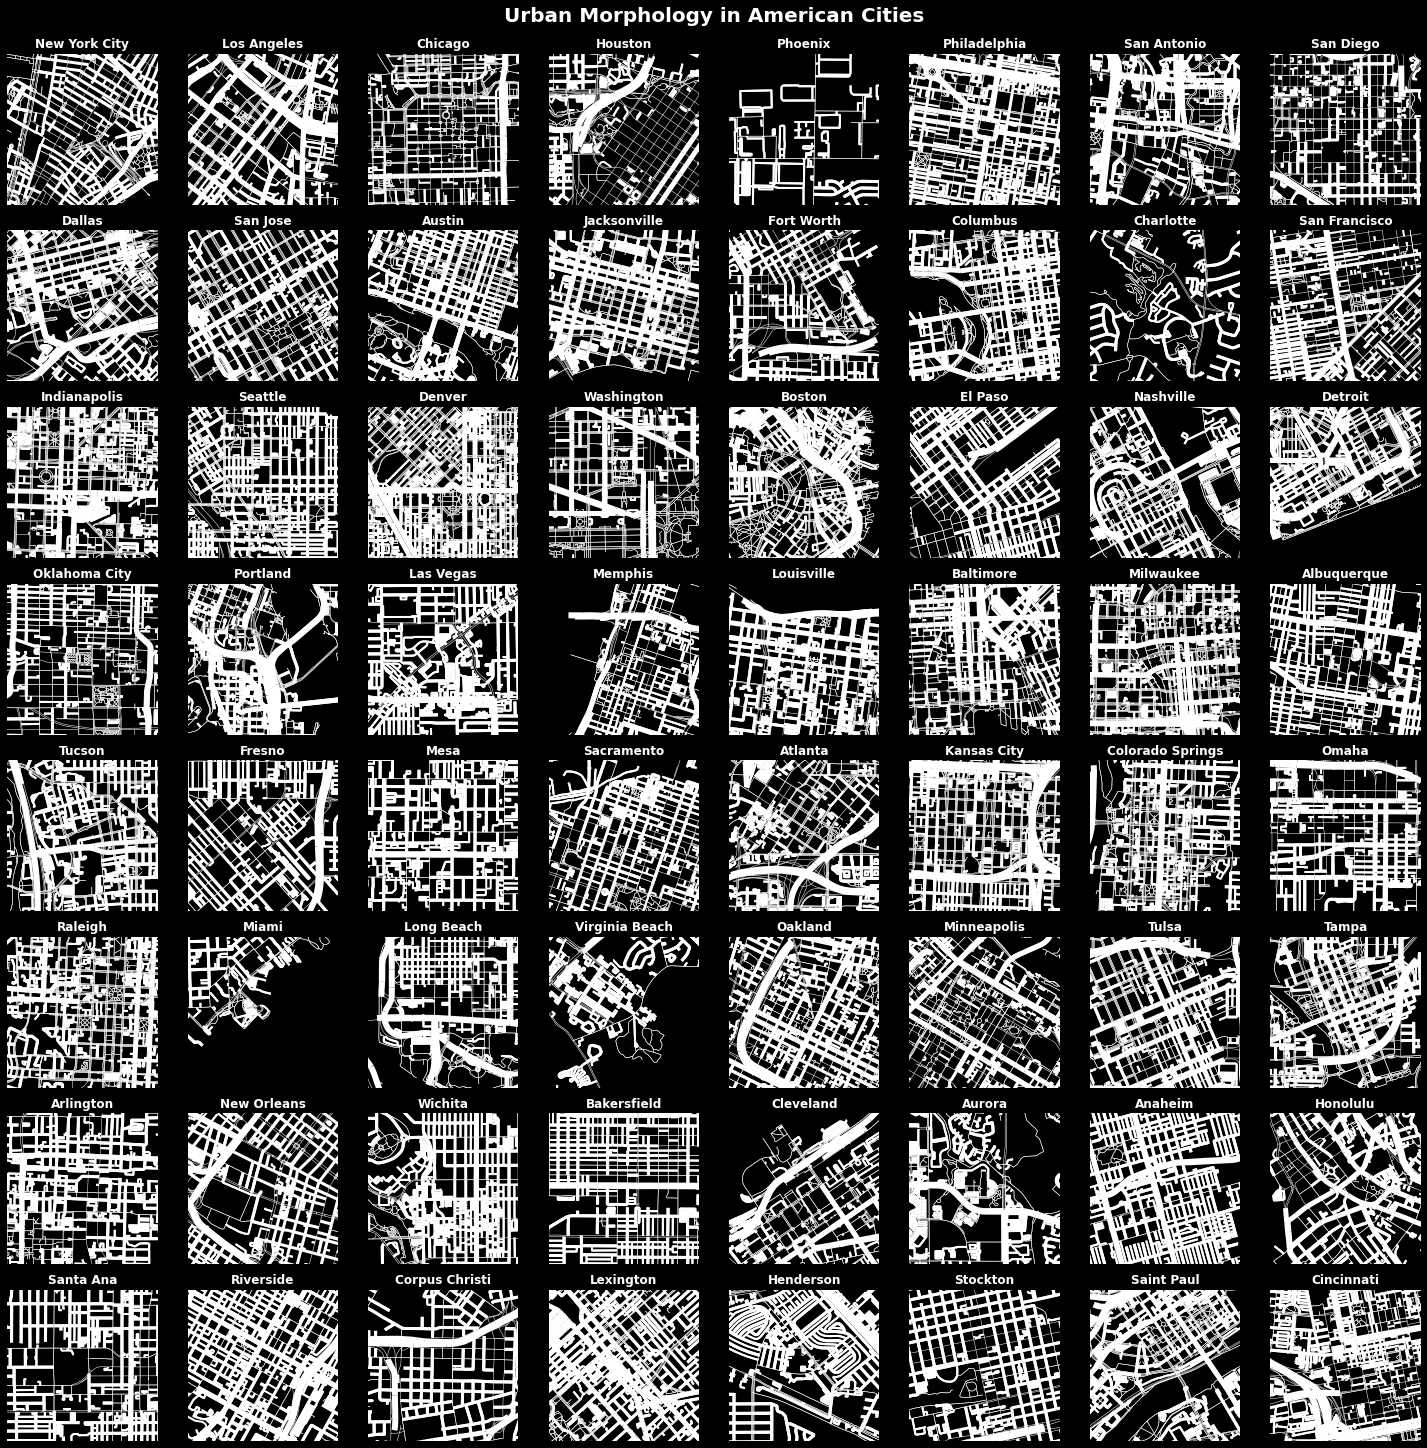

In [119]:
fig, axs = plt.subplots(8, 8, figsize=(20, 20), 
                        facecolor='k',
                        constrained_layout=True, 
                        subplot_kw=dict(aspect='equal'))

axs = axs.ravel()

for i in np.arange(0, 64):
    
    G = ox.graph_from_point((cities['lat'][i], cities['lon'][i]), 
                            dist=1000, 
                            network_type='all')
    
    gdfs = ox.graph_to_gdfs(G)
    
    node = gdfs[0]
    edge = gdfs[1]
    
    edge_linewidths = []
    
    default_width = 0.5
    
    for _, _, d in G.edges(keys=False, data=True):
        street_type = d["highway"][0] if isinstance(d["highway"], list) else d["highway"]
        if street_type in street_widths:
            edge_linewidths.append(street_widths[street_type])
        else:
            edge_linewidths.append(default_width)
    
    edge.plot(ax=axs[i], color='w', lw=edge_linewidths)
    
    bbox = ox.utils_geo.bbox_from_point((cities['lat'][i], cities['lon'][i]), 800, project_utm=False)
    
    north, south, east, west = bbox
    axs[i].set_ylim((south, north))
    axs[i].set_xlim((west, east))
    axs[i].set_title(cities['city'][i], color='w', weight='bold')

    axs[i].margins(0)
    axs[i].axis('off')
    
fig.suptitle('Urban Morphology in American Cities', color='w', size=20, weight='bold')
fig.savefig('urban-morphology.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')

In [120]:
def reverse_bearing(x):
    return x + 180 if x < 180 else x - 180

In [161]:
import datetime

weight_by_length = False

bearings = {}

for i in np.arange(0, len(cities.city[:64])):
    print(datetime.datetime.now(), cities.city[i])
    
    name = cities.city[i]
    
    G = ox.graph_from_point((cities['lat'][i], cities['lon'][i]), 
                            dist=1000, 
                            network_type='all')
    
    U = ox.add_edge_bearings(ox.get_undirected(G))
    
    if weight_by_length:
        
        city_bearings = []
        for u, v, k, d in U.edges(keys=True, data=True):
            city_bearings.extend([d['bearing']] * int(d['length']))
        b = pd.Series(city_bearings)
        bearings[name] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')
        
    else:
        
        b = pd.Series([d['bearing'] for u, v, k, d in U.edges(keys=True, data=True)])
        bearings[i] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')

2020-11-18 17:21:52.898964 New York City
2020-11-18 17:22:02.709006 Los Angeles
2020-11-18 17:22:08.555674 Chicago
2020-11-18 17:22:16.952688 Houston
2020-11-18 17:22:25.238956 Phoenix
2020-11-18 17:22:29.357728 Philadelphia
2020-11-18 17:22:40.746926 San Antonio
2020-11-18 17:22:50.979124 San Diego
2020-11-18 17:22:58.155385 Dallas
2020-11-18 17:23:13.620751 San Jose
2020-11-18 17:23:27.732547 Austin
2020-11-18 17:23:40.648453 Jacksonville
2020-11-18 17:23:53.791217 Fort Worth
2020-11-18 17:24:02.686232 Columbus
2020-11-18 17:24:13.744500 Charlotte
2020-11-18 17:24:19.398160 San Francisco
2020-11-18 17:24:38.012224 Indianapolis
2020-11-18 17:24:48.582083 Seattle
2020-11-18 17:25:03.157596 Denver
2020-11-18 17:25:24.842875 Washington
2020-11-18 17:25:35.587433 Boston
2020-11-18 17:25:51.657400 El Paso
2020-11-18 17:25:58.465009 Nashville
2020-11-18 17:26:08.091802 Detroit
2020-11-18 17:26:20.412405 Oklahoma City
2020-11-18 17:26:31.613989 Portland
2020-11-18 17:26:45.473018 Las Vegas
2

In [162]:
def count_and_merge(n, bearings):
    
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(bearings, bins=bins)
    
    count = np.roll(count, 1)
    return count[::2] + count[1::2]

In [173]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors

mpl.rcParams.update({'text.color':"white",
                     'axes.labelcolor':"white"})

def polar_plot(ax, bearings, n=36, title=''):

    bins = np.arange(n + 1) * 360 / n
    count = count_and_merge(n, bearings)
    _, division = np.histogram(bearings, bins=bins)
    frequency = count / count.sum()
    division = division[0:-1]
    width =  2 * np.pi / n

    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')

    x = division * np.pi / 180
    bars = ax.bar(x, height=frequency, width=width, align='center', bottom=0, zorder=2, 
                  color='w', edgecolor='w', linewidth=0.1, alpha=1)
    
    ax.set_ylim(top=frequency.max())
    
    title_font = {'weight':'bold'}
    xtick_font = {'weight':'bold', 'alpha':1.0, 'zorder':3}
    ytick_font = {'weight':'bold', 'alpha':0.2, 'zorder':3}
    
    ax.set_title(title.upper(), y=1.05, fontdict=title_font)
    
    ax.set_facecolor('k')
    
    ax.set_yticks(np.linspace(0, max(ax.get_ylim()), 5))
    yticklabels = ['{:.2f}'.format(y) for y in ax.get_yticks()]
    yticklabels[0] = ''
    ax.set_yticklabels(labels=yticklabels, fontdict=ytick_font)
    
    xticklabels = ['N', '', 'E', '', 'S', '', 'W', '']
    ax.set_xticklabels(labels=xticklabels, fontdict=xtick_font)
    ax.tick_params(axis='x', which='major', pad=-2)
    
    ax.margins(0)

In [164]:
cities['key'] = pd.Series(np.array(list(bearings.keys())), dtype = 'int')
cities.head()

,city,state,lat,lon,geometry,key
0,New York City,New York,40.713524,-74.006710,POINT (-74.00671 40.71352),0.0
1,Los Angeles,California,34.053714,-118.242653,POINT (-118.24265 34.05371),1.0
2,Chicago,Illinois,41.883823,-87.632078,POINT (-87.63208 41.88382),2.0
3,Houston,Texas,29.760159,-95.369418,POINT (-95.36942 29.76016),3.0
4,Phoenix,Arizona,33.439971,-112.204870,POINT (-112.20487 33.43997),4.0


In [166]:
keys = np.array(list(bearings.keys()))

plots = keys[0:64]
reset = cities.set_index('key')

trim = reset.loc[keys, :]

/Users/andrewrenninger/anaconda3/envs/musa-550-fall-2020/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator


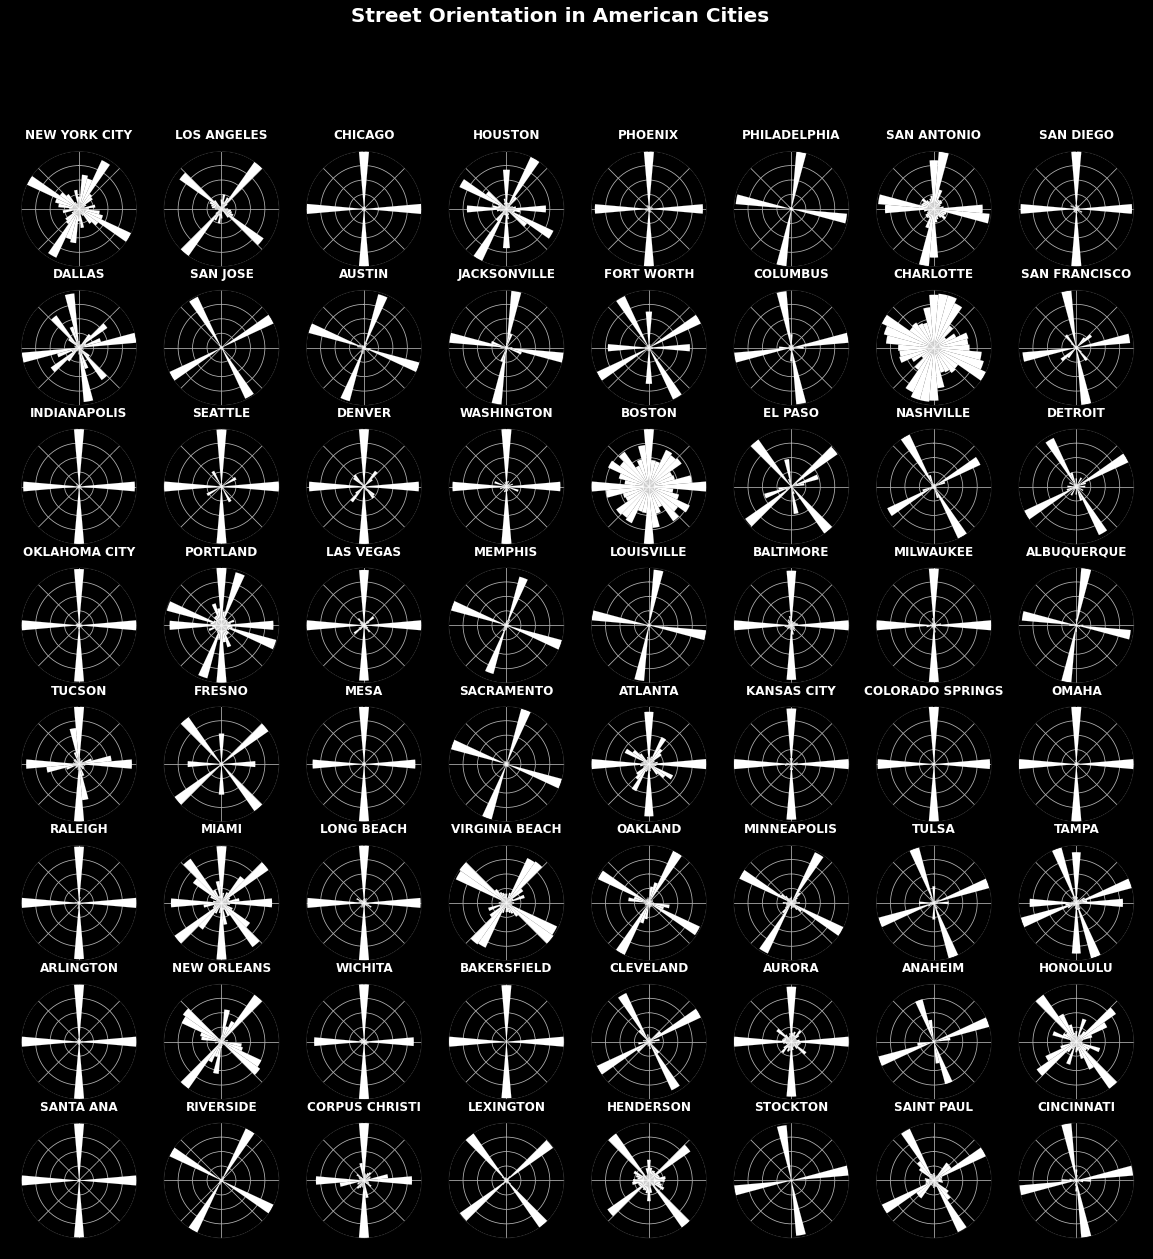

In [180]:
n = 64
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))
figsize = (ncols * 5, nrows * 5)
fig, axs = plt.subplots(nrows, ncols, 
                         facecolor='k',
                         figsize=(20,20), 
                         subplot_kw={'projection':'polar'})

for ax, city in zip(axs.flat, plots):
    polar_plot(ax, bearings[city], title=trim.city[city])

fig.suptitle('Street Orientation in American Cities', color='w', size=20, weight='bold')
fig.savefig('urban-orientation.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')


In [ ]:
def plot_figure_ground(
    G=None,
    address=None,
    point=None,
    dist=805,
    network_type="drive_service",
    street_widths=None,
    default_width=4,
    figsize=(8, 8),
    edge_color="w",
    smooth_joints=True,
    **pg_kwargs,
):
    """
    Plot a figure-ground diagram of a street network.
    Parameters
    ----------
    G : networkx.MultiDiGraph
        input graph, must be unprojected
    address : string
        address to geocode as the center point if G is not passed in
    point : tuple
        center point if address and G are not passed in
    dist : numeric
        how many meters to extend north, south, east, west from center point
    network_type : string
        what type of network to get
    street_widths : dict
        dict keys are street types and values are widths to plot in pixels
    default_width : numeric
        fallback width in pixels for any street type not in street_widths
    figsize : numeric
        (width, height) of figure, should be equal
    edge_color : string
        color of the edges' lines
    smooth_joints : bool
        if True, plot nodes same width as streets to smooth line joints and
        prevent cracks between them from showing
    pg_kwargs
        keyword arguments to pass to plot_graph
    Returns
    -------
    fig, ax : tuple
        matplotlib figure, axis
    """
    multiplier = 1.2

    # if user did not pass in custom street widths, create a dict of defaults
    if street_widths is None:
        street_widths = {
            "footway": 1.5,
            "steps": 1.5,
            "pedestrian": 1.5,
            "service": 1.5,
            "path": 1.5,
            "track": 1.5,
            "motorway": 6,
        }

    # if G was passed in, plot it centered on its node centroid
    if G is not None:
        gdf_nodes = utils_graph.graph_to_gdfs(G, edges=False, node_geometry=True)
        lnglat_point = gdf_nodes.unary_union.centroid.coords[0]
        point = tuple(reversed(lnglat_point))

    # otherwise get network by address or point (whichever was passed) using a
    # dist multiplier to ensure we get more than enough network. simplify in
    # non-strict mode to not combine multiple street types into single edge
    elif address is not None:
        G, point = graph.graph_from_address(
            address,
            dist=dist * multiplier,
            dist_type="bbox",
            network_type=network_type,
            simplify=False,
            truncate_by_edge=True,
            return_coords=True,
        )
        G = simplification.simplify_graph(G, strict=False)
    elif point is not None:
        G = graph.graph_from_point(
            point,
            dist=dist * multiplier,
            dist_type="bbox",
            network_type=network_type,
            simplify=False,
            truncate_by_edge=True,
        )
        G = simplification.simplify_graph(G, strict=False)
    else:
        raise ValueError("You must pass an address or lat-lng point or graph.")

    # we need an undirected graph to find every edge incident to a node
    Gu = utils_graph.get_undirected(G)

    # for each edge, get a linewidth according to street type
    edge_linewidths = []
    for _, _, d in Gu.edges(keys=False, data=True):
        street_type = d["highway"][0] if isinstance(d["highway"], list) else d["highway"]
        if street_type in street_widths:
            edge_linewidths.append(street_widths[street_type])
        else:
            edge_linewidths.append(default_width)

    if smooth_joints:
        # for each node, get a nodesize according to the narrowest incident edge
        node_widths = dict()
        for node in Gu.nodes():
            # first, identify all the highway types of this node's incident edges
            ie_data = [Gu.get_edge_data(node, nbr) for nbr in Gu.neighbors(node)]
            edge_types = [d[min(d)]["highway"] for d in ie_data]
            if len(edge_types) < 1:
                # if node has no incident edges, make size zero
                node_widths[node] = 0
            else:
                # flatten the list of edge types
                et_flat = []
                for et in edge_types:
                    if isinstance(et, list):
                        et_flat.extend(et)
                    else:
                        et_flat.append(et)

                # lookup corresponding width for each edge type in flat list
                edge_widths = [
                    street_widths[et] if et in street_widths else default_width for et in et_flat
                ]

                # node diameter should equal largest edge width to make joints
                # perfectly smooth. alternatively use min(?) to prevent
                # anything larger from extending past smallest street's line.
                # circle marker sizes are in area, so use diameter squared.
                circle_diameter = max(edge_widths)
                circle_area = circle_diameter ** 2
                node_widths[node] = circle_area

        # assign the node size to each node in the graph
        node_sizes = [node_widths[node] for node in Gu.nodes()]
    else:
        node_sizes = 0

    # define the view extents of the plotting figure
    bbox = utils_geo.bbox_from_point(point, dist, project_utm=False)

    # plot the figure
    override = {"bbox", "node_size", "node_color", "edge_linewidth"}
    kwargs = {k: v for k, v in pg_kwargs.items() if k not in override}
    fig, ax = plot_graph(
        G=Gu,
        bbox=bbox,
        figsize=figsize,
        node_size=node_sizes,
        node_color=edge_color,
        edge_color=edge_color,
        edge_linewidth=edge_linewidths,
        **kwargs,
    )
    return fig, ax

In [ ]:
def plot_graph(
    G,
    ax=None,
    figsize=(8, 8),
    bgcolor="#111111",
    node_color="w",
    node_size=15,
    node_alpha=None,
    node_edgecolor="none",
    node_zorder=1,
    edge_color="#999999",
    edge_linewidth=1,
    edge_alpha=None,
    show=True,
    close=False,
    save=False,
    filepath=None,
    dpi=300,
    bbox=None,
):
    """
    Plot a graph.
    Parameters
    ----------
    G : networkx.MultiDiGraph
        input graph
    ax : matplotlib axis
        if not None, plot on this preexisting axis
    figsize : tuple
        if ax is None, create new figure with size (width, height)
    bgcolor : string
        background color of plot
    node_color : string or list
        color(s) of the nodes
    node_size : int
        size of the nodes: if 0, then skip plotting the nodes
    node_alpha : float
        opacity of the nodes, note: if you passed RGBA values to node_color,
        set node_alpha=None to use the alpha channel in node_color
    node_edgecolor : string
        color of the nodes' markers' borders
    node_zorder : int
        zorder to plot nodes: edges are always 1, so set node_zorder=0 to plot
        nodes below edges
    edge_color : string or list
        color(s) of the edges' lines
    edge_linewidth : float
        width of the edges' lines: if 0, then skip plotting the edges
    edge_alpha : float
        opacity of the edges, note: if you passed RGBA values to edge_color,
        set edge_alpha=None to use the alpha channel in edge_color
    show : bool
        if True, call pyplot.show() to show the figure
    close : bool
        if True, call pyplot.close() to close the figure
    save : bool
        if True, save the figure to disk at filepath
    filepath : string
        if save is True, the path to the file. file format determined from
        extension. if None, use settings.imgs_folder/image.png
    dpi : int
        if save is True, the resolution of saved file
    bbox : tuple
        bounding box as (north, south, east, west). if None, will calculate
        from spatial extents of plotted geometries.
    Returns
    -------
    fig, ax : tuple
        matplotlib figure, axis
    """
    max_node_size = max(node_size) if hasattr(node_size, "__iter__") else node_size
    max_edge_lw = max(edge_linewidth) if hasattr(edge_linewidth, "__iter__") else edge_linewidth
    if max_node_size <= 0 and max_edge_lw <= 0:
        raise ValueError("Either node_size or edge_linewidth must be > 0 to plot something.")

    # create fig, ax as needed
    utils.log("Begin plotting the graph...")
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, facecolor=bgcolor, frameon=False)
        ax.set_facecolor(bgcolor)
    else:
        fig = ax.figure

    if max_edge_lw > 0:
        # plot the edges' geometries
        gdf_edges = utils_graph.graph_to_gdfs(G, nodes=False)["geometry"]
        ax = gdf_edges.plot(ax=ax, color=edge_color, lw=edge_linewidth, alpha=edge_alpha, zorder=1)

    if max_node_size > 0:
        # scatter plot the nodes' x/y coordinates
        gdf_nodes = utils_graph.graph_to_gdfs(G, edges=False, node_geometry=False)[["x", "y"]]
        ax.scatter(
            x=gdf_nodes["x"],
            y=gdf_nodes["y"],
            s=node_size,
            c=node_color,
            alpha=node_alpha,
            edgecolor=node_edgecolor,
            zorder=node_zorder,
        )

    # get spatial extents from bbox parameter or the edges' geometries
    padding = 0
    if bbox is None:
        try:
            west, south, east, north = gdf_edges.total_bounds
        except NameError:
            west, south = gdf_nodes.min()
            east, north = gdf_nodes.max()
        bbox = north, south, east, west
        padding = 0.02  # pad 2% to not cut off peripheral nodes' circles

    # configure axis appearance, save/show figure as specified, and return
    ax = _config_ax(ax, G.graph["crs"], bbox, padding)
    fig, ax = _save_and_show(fig, ax, save, show, close, filepath, dpi)
    utils.log("Finished plotting the graph")
    return fig, ax

In [ ]:
def _config_ax(ax, crs, bbox, padding):
    """
    Configure axis for display.
    Parameters
    ----------
    ax : matplotlib axis
        the axis containing the plot
    crs : dict or string or pyproj.CRS
        the CRS of the plotted geometries
    bbox : tuple
        bounding box as (north, south, east, west)
    padding : float
        relative padding to add around the plot's bbox
    Returns
    -------
    ax : matplotlib axis
        the configured/styled axis
    """
    # set the axis view limits to bbox + relative padding
    north, south, east, west = bbox
    padding_ns = (north - south) * padding
    padding_ew = (east - west) * padding
    ax.set_ylim((south - padding_ns, north + padding_ns))
    ax.set_xlim((west - padding_ew, east + padding_ew))

    # set margins to zero, point ticks inward, turn off ax border and x/y axis
    # so there is no space around the plot
    ax.margins(0)
    ax.tick_params(which="both", direction="in")
    _ = [s.set_visible(False) for s in ax.spines.values()]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # set aspect ratio
    if crs == settings.default_crs:
        # if data are not projected, conform aspect ratio to not stretch plot
        coslat = np.cos((south + north) / 2.0 / 180.0 * np.pi)
        ax.set_aspect(1.0 / coslat)
    else:
        # if projected, make everything square
        ax.set_aspect("equal")

    return ax

In [ ]:
cities = pd.read_htlm("https://en.wikipedia.org/wiki/List_of_countries_by_largest_and_second_largest_cities")
cities = cities[0]